## Surface Runoff metric
This notebook briefly walks through how to calculate the flooding exposure metric `absolute change in 99th percentile surface runoff` from Cal-Adapt: Analytics Engine data. This notebook may be expanded upon for inclusion in cae-notebooks in the future.

Order of operations:
1. Read data in
2. Calculate base function (FFWI, SPEI, warm nights, etc.)
3. Calculate chronic
4. Calculate delta signal
5. Reprojection to census tracts
6. Min-max standardization
7. Export data

Runtime: This notebook takes approximately ~3 hours to run due to data size, warming levels, and reprojection steps.

### Step 0: Import libraries

In [1]:
import climakitae as ck
from climakitae.core.data_interface import DataParameters
from climakitae.explore import warming_levels 
from climakitae.util.utils import add_dummy_time_to_wl
import pandas as pd
import numpy as np
import geopandas as gpd

import pyproj
import rioxarray as rio
import xarray as xr

# projection information
import cartopy.crs as ccrs
crs = ccrs.LambertConformal(
    central_longitude=-70, 
    central_latitude=38, 
    false_easting=0.0, 
    false_northing=0.0,  
    standard_parallels=[30, 60], 
    globe=None, 
    # cutoff=-30
)

In [2]:
sims_wl = [
    'WRF_MPI-ESM1-2-HR_r3i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_MIROC6_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_EC-Earth3_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_TaiESM1_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
]
sims_hist = [
    'WRF_MPI-ESM1-2-HR_r3i1p1f1',
    'WRF_MIROC6_r1i1p1f1', 
    'WRF_EC-Earth3_r1i1p1f1',
    'WRF_TaiESM1_r1i1p1f1', 
]

sim_name_dict = dict(zip(sims_wl,sims_hist)) 

In [3]:
def reproject_to_tracts(ds_delta, ca_boundaries):
    # this step takes about 12 minutes with 3km data (~1 min with 9km data)
    df = ds_delta.to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x,df.y))
    gdf = gdf.set_crs(crs)
    gdf = gdf.to_crs(ca_boundaries.crs)
    
    ca_boundaries = ca_boundaries.set_index(['GEOID'])    

    clipped_gdf = gpd.sjoin_nearest(ca_boundaries, gdf, how='left')
    clipped_gdf = clipped_gdf.drop(['index_right'], axis=1)
    clipped_gdf = clipped_gdf.reset_index()[
        ["GEOID",f"{ds_delta.name}","geometry"]]
    ### some coastal tracts do not contain any land grid cells ###
    
    # aggregate the gridded data to the tract level
    clipped_gdf_diss = clipped_gdf.reset_index().dissolve(
        by='GEOID', aggfunc='mean')
    clipped_gdf_diss = clipped_gdf_diss.rename(
        columns={f"{ds_delta.name}_right":
                 ds_delta.name}
    )
    
    # separate tracts with data from tracts without data
    clipped_gdf_nan = clipped_gdf_diss[np.isnan(
        clipped_gdf_diss[ds_delta.name]
    )]
    clipped_gdf_nan = clipped_gdf_nan[["geometry",ds_delta.name]]
    clipped_gdf_valid = clipped_gdf_diss[~np.isnan(
        clipped_gdf_diss[ds_delta.name]
    )]
    clipped_gdf_valid = clipped_gdf_valid[["geometry",ds_delta.name]]

    # compute the centroid of each tract
    clipped_gdf_nan["centroid"] = clipped_gdf_nan.centroid
    clipped_gdf_nan = clipped_gdf_nan.set_geometry("centroid")
    clipped_gdf_valid["centroid"] = clipped_gdf_valid.centroid
    clipped_gdf_valid = clipped_gdf_valid.set_geometry("centroid")
    
    # fill in missing tracts with values from the closest tract
    # in terms of distance between the tract centroids
    clipped_gdf_filled = clipped_gdf_nan.sjoin_nearest(clipped_gdf_valid, how='left')
    clipped_gdf_filled = clipped_gdf_filled[["geometry_left",f"{ds_delta.name}_right"]]
    clipped_gdf_filled = clipped_gdf_filled.rename(columns={
        "geometry_left":"geometry", f"{ds_delta.name}_right":ds_delta.name
    })
    clipped_gdf_valid = clipped_gdf_valid.drop(columns="centroid")
 
    # concatenate filled-in tracts with the original tract which had data
    gdf_all_tracts = pd.concat([clipped_gdf_valid,clipped_gdf_filled])

    return gdf_all_tracts


def min_max_standardize(df, col):
    '''
    Calculates min and max values for specified columns, then calculates
    min-max standardized values.

    Parameters
    ----------
    df: DataFrame
        Input dataframe   
    cols_to_run_on: list
        List of columns to calculate min, max, and standardize
    '''
    max_value = df[col].max()
    min_value = df[col].min()

    # Get min-max values, standardize, and add columns to df
    prefix = col # Extracting the prefix from the column name
    df[f'{prefix}_min'] = min_value
    df[f'{prefix}_max'] = max_value
    df[f'{prefix}_min_max_standardized'] = ((df[col] - min_value) / (max_value - min_value))

    # note to add checker to make sure new min_max column values arent < 0 > 1
    df[f'{prefix}_min_max_standardized'].loc[df[f'{prefix}_min_max_standardized'] < 0] = 0
    df[f'{prefix}_min_max_standardized'].loc[df[f'{prefix}_min_max_standardized'] > 1] = 1
    
    return df

In [4]:
# retrieve 2 deg C surface runoff data data
wl = warming_levels()
wl.wl_params.enable_hidden_vars = True # how to grab surface runoff data!! sfc runoff is a "hidden var"
wl.wl_params.timescale = "daily"
wl.wl_params.downscaling_method = "Dynamical"
wl.wl_params.variable = "Surface runoff"
wl.wl_params.area_subset = "states"
wl.wl_params.cached_area = ["CA"]
wl.wl_params.warming_levels = ["2.0"]
wl.wl_params.resolution = "9 km"
wl.wl_params.anom = "No"
wl.calculate()
ds = wl.sliced_data["2.0"] # grab 2.0 degC data
ds = ds.sel(all_sims = list(sim_name_dict.keys()))
wl_ds = add_dummy_time_to_wl(ds)
wl_ds

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



Computing each warming level:   0%|          | 0/1 [00:00<?, ?it/s]

Processing data to read 3.52 GB of data into memory... 
[########################################] | 100% Completed | 124.73 s
Complete!


<xarray.DataArray 'Surface runoff' (warming_level: 1, time: 10950, y: 144,
                                    x: 60, all_sims: 4)>
array([[[[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]]]]], dtype=float32)
Coordinates:
  * warming_level      (warming_level) object '2.0'
  * time               (time) datetime64[ns] 2000-01-01 ... 2029-12-23
  * x                  (x) float64 -4.278e+06 -4.269e+06 ... -3.747e+06
  * y                  (y) float64 5.479e+05 5.569e+05 ... 1.826e+06 1.835e+06
    lakemask           (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    landmask           (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 30.96 31.01 31.05 ... 43.34 43.39 43.44
    lon                (y, x) float32 -117.9 -117.8 -117.7 ... -121.6 -121.5
    Lambert_Conformal  int64 0
    centered_year      (all_sims) int64 2045 2053 2034 2040
  * all_sims           (all_sims) <U70 'WRF_MPI-ESM1-2-HR_r3i1p1f1_Historical...
Attributes:
    variable_id:           sfc_runoff
    extended_description:  The rate at which water travels over the ground su...
    units:                 mm/d
    data_type:             Gridded
    resolution:            9 km
    frequency:             daily
    location_subset:       ['CA']
    grid_mapping:          Lambert_Conformal
    institution:           UCLA
    window:                15
    months:                [ 1  2  3  4  5  6  7  8  9 10 11 12]

In [5]:
## Step 1b: Retrieve historical baseline data (1981-2010)
selections = DataParameters()
selections.enable_hidden_vars = True # how to grab surface runoff data!! sfc runoff is a "hidden var"
selections.area_average = 'No'
selections.timescale = 'daily'
selections.downscaling_method = 'Dynamical'
selections.variable = 'Surface runoff'
selections.area_subset = 'states'
selections.cached_area = ['CA']
selections.scenario_historical = ['Historical Climate']
selections.time_slice = (1981, 2010)
selections.resolution = '9 km'
hist_ds = selections.retrieve()
hist_ds = hist_ds.sel(simulation=sims_hist)
hist_ds

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



,Array,Chunk
Bytes,1.41 GiB,21.97 MiB
Shape,"(1, 4, 10957, 144, 60)","(1, 1, 2131, 53, 51)"
Count,90 Graph Layers,576 Chunks
Type,float32,numpy.ndarray


### Step 2: Calculate delta signal

In [6]:
hist_99p = hist_ds.chunk(
    dict(time=-1)).quantile([.99],
    dim='time').compute().squeeze()

wl_99p = wl_ds.chunk(
    dict(time=-1)).quantile([.99],
    dim='time').compute().squeeze()

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [12]:
# average over sim dimension for both
wl_99p = wl_99p.mean(dim='all_sims')
hist_99p = hist_99p.mean(dim='simulation')

<xarray.DataArray 'Surface runoff' (y: 144, x: 60)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    warming_level  <U3 '2.0'
  * x              (x) float64 -4.278e+06 -4.269e+06 ... -3.756e+06 -3.747e+06
  * y              (y) float64 5.479e+05 5.569e+05 ... 1.826e+06 1.835e+06
    lakemask       (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    landmask       (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    lat            (y, x) float32 30.96 31.01 31.05 31.1 ... 43.34 43.39 43.44
    lon            (y, x) float32 -117.9 -117.8 -117.7 ... -121.7 -121.6 -121.5
    quantile       float64 0.99
Attributes:
    variable_id:           sfc_runoff
    extended_description:  The rate at which water travels over the ground su...
    units:                 mm/d
    data_type:             Gridded
    resolution:            9 km
    frequency:             daily
    location_subset:       ['CA']
    grid_mapping:          Lambert_Conformal
    institution:           UCLA
    window:                15
    months:                [ 1  2  3  4  5  6  7  8  9 10 11 12]

In [13]:
delta_sfcrun = (wl_99p - hist_99p)
delta_sfcrun.name = 'surface_runoff' # rename metric to be friendly for our remaining process

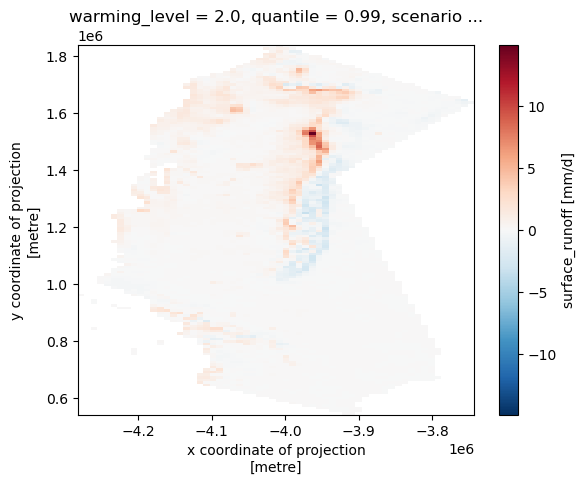

In [14]:
delta_sfcrun.plot()

### Step 3: Reproject data to census tract projection

In [15]:
# load in census tract shapefile
# census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/" # pcluster run
census_shp_dir = "2021_ca_tract/tl_2021_06_tract.shp" # local run, requires having census tracts loaded in file tree

ca_boundaries = gpd.read_file(census_shp_dir)

# convert to area-preserving CRS
ca_boundaries = ca_boundaries.to_crs(crs=3310)
sfcrun_df = reproject_to_tracts(delta_sfcrun, ca_boundaries)

### Step 4: Min-max standardization

In [16]:
# Using Cal-CRAI min-max standardization function, available in `utils.calculate_index.py`
sfcrun_std = min_max_standardize(sfcrun_df, col=delta_sfcrun.name)

### Step 5: Export as csv

In [17]:
# clean up dataframes prior to export
sfcrun_std = sfcrun_std.drop(columns=['geometry'])

# export
sfcrun_std.to_csv('climate_flood_exposure_surface_runoff_metric.csv')

In [18]:
sfcrun_std

,surface_runoff,surface_runoff_min,surface_runoff_max,surface_runoff_min_max_standardized
GEOID,,,,
06001401700,1.275314,-2.76177,4.642036,0.545272
06001401800,1.275314,-2.76177,4.642036,0.545272
06001402200,1.275314,-2.76177,4.642036,0.545272
06001402500,1.275314,-2.76177,4.642036,0.545272
06001402600,1.275314,-2.76177,4.642036,0.545272
...,...,...,...,...
06111008900,1.234167,-2.76177,4.642036,0.539714
06111009100,1.234167,-2.76177,4.642036,0.539714
06111009200,1.234167,-2.76177,4.642036,0.539714
